# Program

## run 1 : trained on 10 episodes and 10 batch size


[*********************100%%**********************]  5 of 5 completed


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Episode: 9/10, Total Reward: 1546918.8487644661
1/1 [==============================] - 0s 27ms/step
Episode: 10/10, Total Reward: 1636928.4137740098


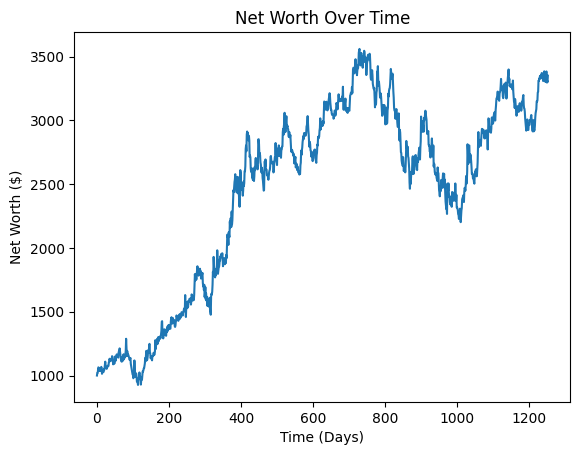

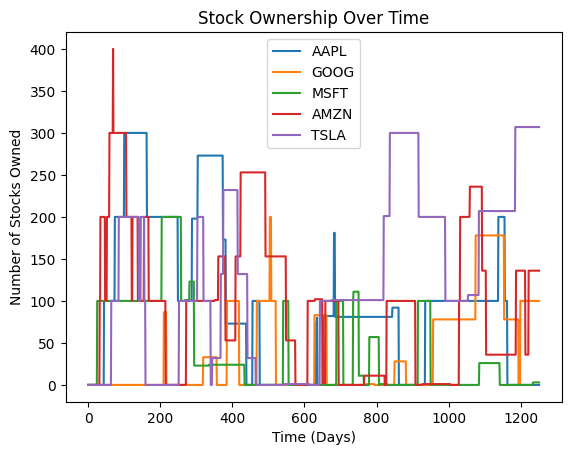

Initial investment amount $ 1000
Stocks investment done in:  AAPL GOOG MSFT AMZN TSLA
Final Net Worth: $3351.20


In [19]:
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import matplotlib.pyplot as plt
from collections import deque

# Function to preprocess data
def preprocess_data(data):
    if data.size == 0:
        return np.zeros((1, 1))
    data = np.array(data)
    data = data / np.max(data, axis=0)
    return data

# Function to build DQN model
def build_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(output_shape, activation='linear')
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) # Compiling the model
    return model

# Function to select action based on epsilon-greedy policy
def select_action(model, state, epsilon, action_space):
    if np.random.rand() <= epsilon:
        return random.randrange(action_space)
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# Define environment class
class StockMarketEnv:
    def __init__(self, data, window_size, initial_balance):
        self.data = data
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = window_size
        self.num_stocks = data.shape[1] - 1
        self.action_space = self.num_stocks * 2
        self.observation_space = (self.num_stocks * 2) + 1
        self.stock_owned = [0] * self.num_stocks
        self.balance = initial_balance
        self.stock_prices = None
        self.stock_owned_history = []

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.stock_owned = [0] * self.num_stocks
        self.stock_owned_history = []
        return self._next_observation()

    def step(self, action):
        self.current_step += 1
        reward = 0
        if self.current_step >= len(self.data) - 1:
            return None, 0, True, {}
        else:
            reward = self._take_action(action) # Storing the reward for the given action
        done = self.current_step >= len(self.data) - 1
        obs = self._next_observation()
        return obs, reward, done, {}

    def _take_action(self, action):
        stock_price = self.data[self.current_step][1:]
        stock_index = action // 2
        is_sell_action = action % 2 != 0

        if is_sell_action:
            action_price = stock_price[stock_index]
            if action_price > 0 and self.stock_owned[stock_index] > 0:
                stock_sell = min(self.stock_owned[stock_index], 100) # Setting transaction limit
                self.stock_owned[stock_index] -= stock_sell
                self.balance += stock_sell * action_price
                return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price))
        else:
            action_price = stock_price[stock_index]
            if action_price > 0:
                stock_buy = min((self.balance * 0.99) // action_price, 100) # Setting transaction limit
                self.stock_owned[stock_index] += stock_buy
                self.balance -= stock_buy * action_price
                return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price))

        return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price)) # Returning the reward

    def _next_observation(self):
        window_size = self.window_size + 1
        obs = np.zeros(self.observation_space)
        if self.current_step < window_size:
            return obs
        for i in range(self.num_stocks):
            obs[i] = self.stock_owned[i] / 100 # Buy or sell
        for i in range(self.num_stocks, self.num_stocks * 2):
            obs[i] = self.stock_owned[i - self.num_stocks] / 100 # Buy or sell
        obs[-1] = self.data[self.current_step, 0] / 100
        return obs

    def set_stock_prices(self, prices):
        self.stock_prices = prices

# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size): # Batch sampling
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# DQN training function
def train_dqn(env, model, target_model, episodes, epsilon, epsilon_min, epsilon_decay, batch_size, gamma, target_update_freq, replay_buffer_size):
    replay_buffer = ReplayBuffer(replay_buffer_size)

    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.observation_space])  # Adjusting the input shape
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() <= epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(model.predict(state))

            next_state, reward, done, _ = env.step(action)
            if next_state is None:
                break

            next_state = np.reshape(next_state, [1, env.observation_space])  # Adjusting the input shape
            total_reward += reward

            # Add experience to replay buffer
            replay_buffer.add((state, action, reward, next_state, done))

            # Sample a random batch from replay buffer
            if len(replay_buffer.buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = np.reshape(states, [batch_size, env.observation_space])
                next_states = np.reshape(next_states, [batch_size, env.observation_space])

                # Calculate target Q values using the target network
                target_q_values = target_model.predict(next_states)
                target_q_values[dones] = 0  # Q value for terminal states is 0
                targets = rewards + gamma * np.amax(target_q_values, axis=1)

                # Update model
                model.fit(states, model.predict(states), verbose=0)  # Warm-up the model
                model_targets = model.predict(states)
                model_targets[np.arange(len(model_targets)), actions] = targets
                model.fit(states, model_targets, verbose=0)

                # Update target network
                if episode % target_update_freq == 0:
                    target_model.set_weights(model.get_weights())

            state = next_state

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print(f"Episode: {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Load data
stocks = "AAPL GOOG MSFT AMZN TSLA" # Tradable stocks
data = yf.download(stocks, start="2014-01-01", end="2024-01-01") # Collecting the data from yfinance

# Preprocess data
data = data.fillna(method="ffill")
data = preprocess_data(data)

# Define hyperparameters
window_size = 4
episodes = 10
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 10
gamma = 0.99

# Create environment
initial_balance = int(input("Enter the initial investment amount: "))
env = StockMarketEnv(data[:len(data) // 2], window_size, initial_balance) # Training on first half of last 10 year data
env.set_stock_prices(data[:len(data) // 2]) # Setting the stock prices

# Build DQN model
input_shape = (env.observation_space,)
output_shape = env.action_space
model = build_model(input_shape, output_shape)
target_model = build_model(input_shape, output_shape)

# Train DQN model
train_dqn(env, model, target_model, episodes, epsilon, epsilon_min, epsilon_decay, batch_size, gamma, 10, 1000) # Training the DQN model

# Simulate trading on test data and visualize results
test_env = StockMarketEnv(data[len(data) // 2:], window_size, initial_balance) # Trading on second half of last 10 year data
test_env.set_stock_prices(data[len(data) // 2:]) # Setting the stock prices
state = test_env.reset()
state = np.reshape(state, [1, test_env.observation_space])
done = False
total_reward = 0
net_worth_history = []
stock_owned_history = []
while not done:
    action = select_action(model, state, epsilon, test_env.action_space)
    next_state, reward, done, _ = test_env.step(action)
    if next_state is None: # Break in case we reach a None state
        break
    next_state = np.reshape(next_state, [1, test_env.observation_space])
    total_reward += reward

    # Calculate net worth including cash and market values of stocks
    net_worth = test_env.balance
    for i, stock in enumerate(test_env.stock_owned):
        net_worth += stock * test_env.stock_prices[test_env.current_step - test_env.window_size][i]
    net_worth_history.append(net_worth)

    # Update the stock ownership history
    current_stock_owned = []
    for i in range(len(stocks.split())):
        current_stock_owned.append(test_env.stock_owned[i])
    stock_owned_history.append(current_stock_owned)

    state = next_state

# Plot net worth over time starting from initial balance
initial_balance = test_env.initial_balance
net_worth_history = [initial_balance] + net_worth_history  # Include initial balance
plt.plot(net_worth_history)
plt.title('Net Worth Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Net Worth ($)')
plt.show()

# Plot stock ownership over time
stocks_labels = stocks.split()
for i in range(len(stock_owned_history[0])):
    plt.plot([stock[i] for stock in stock_owned_history], label=stocks_labels[i])
plt.title('Stock Ownership Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Stocks Owned')
plt.legend()
plt.show()

# Output final net worth
final_net_worth = net_worth_history[-1]
print("Initial investment amount $", initial_balance)
print("Stocks investment done in: ", stocks)
print(f"Final Net Worth: ${final_net_worth:.2f}")


## run 2 : trained on 15 episodes and 20 batch size


[*********************100%%**********************]  5 of 5 completed


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
Episode: 14/15, Total Reward: 1828978.593819656
1/1 [==============================] - 0s 56ms/step
Episode: 15/15, Total Reward: 1870594.0270462788


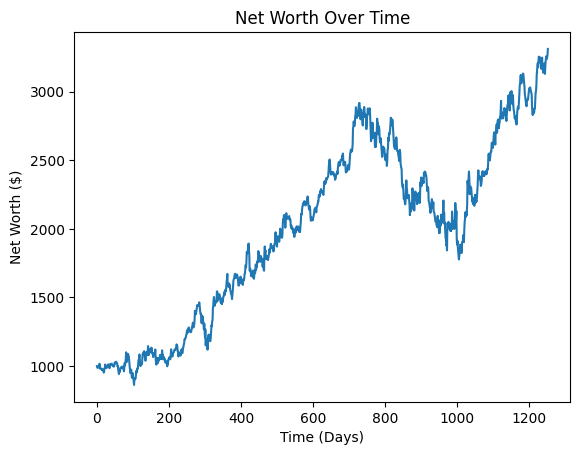

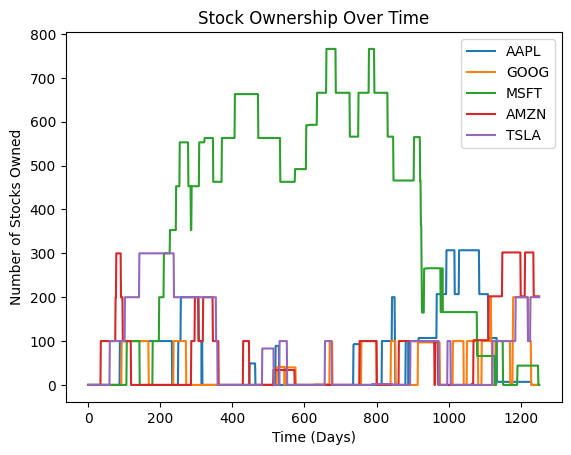

Initial investment amount $ 1000
Stocks investment done in:  AAPL GOOG MSFT AMZN TSLA
Final Net Worth: $3311.07


In [20]:
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import matplotlib.pyplot as plt
from collections import deque

# Function to preprocess data
def preprocess_data(data):
    if data.size == 0:
        return np.zeros((1, 1))
    data = np.array(data)
    data = data / np.max(data, axis=0)
    return data

# Function to build DQN model
def build_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(output_shape, activation='linear')
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) # Compiling the model
    return model

# Function to select action based on epsilon-greedy policy
def select_action(model, state, epsilon, action_space):
    if np.random.rand() <= epsilon:
        return random.randrange(action_space)
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# Define environment class
class StockMarketEnv:
    def __init__(self, data, window_size, initial_balance):
        self.data = data
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = window_size
        self.num_stocks = data.shape[1] - 1
        self.action_space = self.num_stocks * 2
        self.observation_space = (self.num_stocks * 2) + 1
        self.stock_owned = [0] * self.num_stocks
        self.balance = initial_balance
        self.stock_prices = None
        self.stock_owned_history = []

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.stock_owned = [0] * self.num_stocks
        self.stock_owned_history = []
        return self._next_observation()

    def step(self, action):
        self.current_step += 1
        reward = 0
        if self.current_step >= len(self.data) - 1:
            return None, 0, True, {}
        else:
            reward = self._take_action(action) # Storing the reward for the given action
        done = self.current_step >= len(self.data) - 1
        obs = self._next_observation()
        return obs, reward, done, {}

    def _take_action(self, action):
        stock_price = self.data[self.current_step][1:]
        stock_index = action // 2
        is_sell_action = action % 2 != 0

        if is_sell_action:
            action_price = stock_price[stock_index]
            if action_price > 0 and self.stock_owned[stock_index] > 0:
                stock_sell = min(self.stock_owned[stock_index], 100) # Setting transaction limit
                self.stock_owned[stock_index] -= stock_sell
                self.balance += stock_sell * action_price
                return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price))
        else:
            action_price = stock_price[stock_index]
            if action_price > 0:
                stock_buy = min((self.balance * 0.99) // action_price, 100) # Setting transaction limit
                self.stock_owned[stock_index] += stock_buy
                self.balance -= stock_buy * action_price
                return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price))

        return self.balance + np.sum(np.array(self.stock_owned) * np.array(stock_price))

    def _next_observation(self):
        window_size = self.window_size + 1
        obs = np.zeros(self.observation_space)
        if self.current_step < window_size:
            return obs
        for i in range(self.num_stocks):
            obs[i] = self.stock_owned[i] / 100 # Buy or sell
        for i in range(self.num_stocks, self.num_stocks * 2):
            obs[i] = self.stock_owned[i - self.num_stocks] / 100 # Buy or sell
        obs[-1] = self.data[self.current_step, 0] / 100
        return obs

    def set_stock_prices(self, prices):
        self.stock_prices = prices

# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size): # Batch sampling
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# DQN training function
def train_dqn(env, model, target_model, episodes, epsilon, epsilon_min, epsilon_decay, batch_size, gamma, target_update_freq, replay_buffer_size):
    replay_buffer = ReplayBuffer(replay_buffer_size)

    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.observation_space])  # Adjusting the input shape
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() <= epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(model.predict(state))

            next_state, reward, done, _ = env.step(action)
            if next_state is None:
                break

            next_state = np.reshape(next_state, [1, env.observation_space])  # Adjusting the input shape
            total_reward += reward

            # Add experience to replay buffer
            replay_buffer.add((state, action, reward, next_state, done))

            # Sample a random batch from replay buffer
            if len(replay_buffer.buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = np.reshape(states, [batch_size, env.observation_space])
                next_states = np.reshape(next_states, [batch_size, env.observation_space])

                # Calculate target Q values using the target network
                target_q_values = target_model.predict(next_states)
                target_q_values[dones] = 0  # Q value for terminal states is 0
                targets = rewards + gamma * np.amax(target_q_values, axis=1)

                # Update model
                model.fit(states, model.predict(states), verbose=0)  # Warm-up the model
                model_targets = model.predict(states)
                model_targets[np.arange(len(model_targets)), actions] = targets
                model.fit(states, model_targets, verbose=0)

                # Update target network
                if episode % target_update_freq == 0:
                    target_model.set_weights(model.get_weights())

            state = next_state

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print(f"Episode: {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Load data
stocks = "AAPL GOOG MSFT AMZN TSLA" # Tradable stocks
data = yf.download(stocks, start="2014-01-01", end="2024-01-01") # Collecting the data from yfinance

# Preprocess data
data = data.fillna(method="ffill")
data = preprocess_data(data)

# Define hyperparameters
window_size = 4
episodes = 15
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 20
gamma = 0.99

# Create environment
initial_balance = int(input("Enter the initial investment amount: "))
env = StockMarketEnv(data[:len(data) // 2], window_size, initial_balance) # Training on first half of last 10 year data
env.set_stock_prices(data[:len(data) // 2]) # Setting the stock prices

# Build DQN model
input_shape = (env.observation_space,)
output_shape = env.action_space
model = build_model(input_shape, output_shape)
target_model = build_model(input_shape, output_shape)

# Train DQN model
train_dqn(env, model, target_model, episodes, epsilon, epsilon_min, epsilon_decay, batch_size, gamma, 10, 1000)

# Simulate trading on test data and visualize results
test_env = StockMarketEnv(data[len(data) // 2:], window_size, initial_balance) # Trading on second half of last 10 year data
test_env.set_stock_prices(data[len(data) // 2:]) # Setting the stock prices
state = test_env.reset()
state = np.reshape(state, [1, test_env.observation_space])
done = False
total_reward = 0
net_worth_history = []
stock_owned_history = []
while not done:
    action = select_action(model, state, epsilon, test_env.action_space)
    next_state, reward, done, _ = test_env.step(action)
    if next_state is None: # Break in case we reach a None state
        break
    next_state = np.reshape(next_state, [1, test_env.observation_space])
    total_reward += reward

    # Calculate net worth including cash and market values of stocks
    net_worth = test_env.balance
    for i, stock in enumerate(test_env.stock_owned):
        net_worth += stock * test_env.stock_prices[test_env.current_step - test_env.window_size][i]
    net_worth_history.append(net_worth)

    # Update the stock ownership history
    current_stock_owned = []
    for i in range(len(stocks.split())):
        current_stock_owned.append(test_env.stock_owned[i])
    stock_owned_history.append(current_stock_owned)

    state = next_state

# Plot net worth over time starting from initial balance
initial_balance = test_env.initial_balance
net_worth_history = [initial_balance] + net_worth_history  # Include initial balance
plt.plot(net_worth_history)
plt.title('Net Worth Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Net Worth ($)')
plt.show()

# Plot stock ownership over time
stocks_labels = stocks.split()
for i in range(len(stock_owned_history[0])):
    plt.plot([stock[i] for stock in stock_owned_history], label=stocks_labels[i])
plt.title('Stock Ownership Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Stocks Owned')
plt.legend()
plt.show()

# Output final net worth
final_net_worth = net_worth_history[-1]
print("Initial investment amount $", initial_balance)
print("Stocks investment done in: ", stocks)
print(f"Final Net Worth: ${final_net_worth:.2f}")
